#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[-0.24928723, -0.9651282 ,  0.07989645],
       [-0.33477966,  0.16329781,  0.92803901],
       [-0.90872353,  0.20460057, -0.36381334]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002358


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000292


In [37]:
C1(dx,dy,dz,Ret)

array([[ 1.46747346e-01,  5.73778095e+00,  7.00112118e+00,
         5.28672928e-03,  1.29142797e+00, -1.19022814e+00,
        -4.66859204e-01,  2.89692237e+00, -3.38539046e+00,
         2.55526983e+00,  1.26360941e-01, -5.05476746e-02,
         3.56846246e-01,  1.11102871e+00, -1.47039197e-01,
        -5.90604208e-01,  6.12748468e-01,  1.16740635e+00,
         6.90420405e-04, -1.54088025e+00, -3.23603435e-01,
         2.02553010e+00, -4.66880763e+00,  1.60615269e+00,
        -1.02788613e-03,  4.52224277e-01, -1.23441592e+00,
         4.55108989e-02,  9.58792631e-03,  2.06457093e-01,
        -2.62776322e+00,  1.22393690e+00,  5.84203296e-02,
        -1.19745915e+00, -1.76212166e+00,  5.08559317e-01,
        -1.99620472e-01,  6.18764056e+00, -7.68809401e-01,
         2.58699600e-03,  1.07839770e+00,  8.54419200e+00,
         4.03328354e+00,  1.04401704e+00,  2.42760502e-01,
        -5.65120820e-01, -2.19557364e+00, -9.37743011e-02,
         5.89154741e-01,  1.52618839e+00],
       [ 6.32

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 8.42187997e+02,  3.62795451e+03, -1.78172725e+04],
       [ 3.29293196e+04,  7.90930451e+03,  3.65084536e+03],
       [ 4.01796720e+04,  2.16747307e+02,  7.17491293e+03],
       [ 3.03407188e+01, -2.33030493e+03, -4.24783730e+03],
       [ 7.41154896e+03,  2.83872266e+03, -5.12698247e+02],
       [-6.83075969e+03, -5.97021254e+03,  8.03780231e+03],
       [-2.67932082e+03,  5.77760476e+03,  8.31812910e+02],
       [ 1.66255358e+04, -5.30610720e+02, -3.81977300e+03],
       [-1.94288707e+04,  8.74067705e+03,  1.31156360e+04],
       [ 1.46647803e+04, -3.66340878e+03, -4.70218295e+02],
       [ 7.25189727e+02,  4.60022420e+03, -1.82969055e+03],
       [-2.90094820e+02,  4.14307719e+03, -9.80923962e+02],
       [ 2.04795272e+03, -2.43396273e+03, -1.13428896e+04],
       [ 6.37623148e+03,  5.87346781e+03,  4.05144408e+03],
       [-8.43862940e+02, -3.78947271e+03,  4.63878634e+03],
       [-3.38949759e+03,  1.28553073e+03,  1.51316258e+03],
       [ 3.51658425e+03,  3.13091926e+02

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000363


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000328


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000026


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-7.21117312e-01, -9.83571589e-01,  5.54873224e-01],
       [-1.42379206e-01, -1.31164961e+00, -1.42297294e-01],
       [-1.27520347e+00,  1.60356222e+00, -1.82736830e+00],
       [ 1.10093336e+00, -2.15541415e-01,  1.69229239e-01],
       [ 5.45542244e-01, -7.82756975e-01, -9.04073858e-01],
       [-2.38190087e-01,  2.19409692e-01, -7.29852906e-01],
       [-3.26313830e-01,  1.58879496e+00,  6.09077054e-02],
       [-2.73207520e-01, -1.18374699e-01,  3.01923852e-01],
       [ 1.85279576e+00, -3.65392618e-01,  4.46172666e-01],
       [ 2.84954400e+00, -2.88997506e-02,  2.29539824e-01],
       [-4.80292446e-01,  1.91248802e+00, -1.08959633e+00],
       [ 3.15846645e-01, -1.60072186e-01,  6.63723057e-01],
       [-2.77722167e-01, -5.40806194e-01,  9.95788473e-01],
       [ 2.30745532e-01, -9.03501018e-01, -1.03488683e+00],
       [-1.11937618e+00, -6.17316401e-01, -9.41927121e-01],
       [-1.90610347e+00,  7.78586255e-02, -3.80152206e-02],
       [ 2.07685621e+00,  1.31339435e+00

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000077


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000438


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000785


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-4.34744641e-01,  1.25049845e+00,  3.29543037e-01],
       [-1.74527508e+00,  1.66274758e+00, -1.15538376e+00],
       [ 7.22561685e-01, -2.64632930e+00,  1.44475623e+00],
       [-2.60603175e+00,  1.26217848e+00, -4.02347372e-01],
       [-3.53115784e-01, -5.34313258e-02, -2.38121773e-01],
       [-9.83452014e-01, -1.03250798e+00, -7.25367640e-01],
       [-8.72323342e-02,  1.52464882e+00,  9.38150633e-01],
       [ 1.08070128e+00, -7.03690234e-01,  4.99037458e-01],
       [-1.21247770e+00,  8.63981172e-01,  2.89954817e+00],
       [ 7.10548152e-01,  1.14123707e+00, -1.34042836e+00],
       [-1.13536251e-01,  5.41761990e-01, -1.86174009e-01],
       [ 3.58510093e-01, -6.59584475e-01,  1.80886364e+00],
       [ 2.47408758e-01,  2.37371892e+00,  1.41526504e+00],
       [-2.09716231e-01, -2.90004047e-01, -4.12175325e-01],
       [ 1.10602629e+00,  7.57784117e-01,  1.03690782e+00],
       [-5.78896993e-01, -5.19718573e-01, -5.93035955e-01],
       [-6.55691389e-01,  6.16387795e-01

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.37973171e-02,  1.04577752e-02, -3.08005364e-02,
         3.45234606e-03, -1.13283960e-03, -8.53351235e-03,
        -1.36707463e-02,  3.77721918e-03,  7.28640070e-03,
         2.32488087e-03, -2.69241099e-02,  7.40718893e-03,
         1.38037330e-02, -1.22976813e-03, -2.95420251e-03,
        -1.03900082e-03, -1.49605393e-02, -2.34378046e-04,
         1.74056219e-02,  1.28093255e-02,  1.87350353e-03,
        -2.40319514e-02, -1.53842660e-02,  8.89463975e-03,
        -1.53020213e-02, -1.21666064e-02, -5.46485994e-03,
        -5.94169209e-03, -1.96492600e-02,  4.58830839e-03,
        -1.22142717e-02,  6.93738494e-04,  6.54453162e-03,
         7.57949462e-03,  4.25460719e-03,  1.73718568e-02,
        -1.89952158e-02,  1.60469816e-02, -5.21032124e-04,
        -1.31306496e-03, -1.73993155e-02, -5.41765337e-03,
        -2.19702022e-02,  9.30145996e-03,  1.67062237e-02,
        -9.04950055e-03, -9.73317142e-03, -5.96970974e-03,
        -2.11418012e-03,  2.36370591e-02],
       [-6.19

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001308


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 2.07399571e-06,  5.65448790e-07, -2.12617195e-06,
        -4.42246914e-08,  1.03178651e-06,  1.24169287e-07,
        -3.12338796e-07,  3.75293608e-07, -2.37544912e-06,
         3.57510903e-06, -5.92337618e-07,  8.31678880e-07,
        -1.68123377e-06,  8.81382823e-07, -2.02998717e-07,
         9.65186730e-07, -2.58231354e-06,  7.04253463e-07,
        -1.12644513e-06,  4.96479467e-07,  2.46110580e-08,
        -1.99484494e-06,  2.52190384e-07, -7.05029736e-07,
         2.16315729e-06,  2.67662603e-07, -1.09661356e-06,
        -2.24999152e-06,  9.47021122e-07,  8.41221035e-07,
        -1.18082866e-06, -6.53550135e-07,  1.33793411e-06,
        -4.33096724e-07,  4.02826866e-07,  1.27889722e-06,
         2.35104253e-06,  1.82469937e-06,  1.60764761e-06,
        -3.41307020e-06, -3.89125583e-07,  1.37547303e-06,
        -4.21908634e-07,  1.22714245e-06, -2.82982741e-07,
        -3.25984241e-07, -3.53287578e-06, -2.05873036e-07,
        -7.76499217e-07,  1.43649082e-07],
       [-1.11

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-8.42187997e+02, -3.29293196e+04, -4.01796720e+04,
        -3.03407188e+01, -7.41154896e+03,  6.83075969e+03,
         2.67932082e+03, -1.66255358e+04,  1.94288707e+04,
        -1.46647803e+04, -7.25189727e+02,  2.90094820e+02,
        -2.04795272e+03, -6.37623148e+03,  8.43862940e+02,
         3.38949759e+03, -3.51658425e+03, -6.69978466e+03,
        -3.96234613e+00,  8.84316407e+03,  1.85717110e+03,
        -1.16245860e+04,  2.67944454e+04, -9.21776481e+03,
         5.89907336e+00, -2.59533047e+03,  7.08435483e+03,
        -2.61188593e+02, -5.50254345e+01, -1.18486426e+03,
         1.50808223e+04, -7.02421543e+03, -3.35276254e+02,
         6.87225868e+03,  1.01128760e+04, -2.91863918e+03,
         1.14562866e+03, -3.55110792e+04,  4.41222324e+03,
        -1.48468578e+01, -6.18896102e+03, -4.90354078e+04,
        -2.31471511e+04, -5.99164921e+03, -1.39321076e+03,
         3.24324756e+03,  1.26004716e+04,  5.38173897e+02,
        -3.38117905e+03, -8.75884697e+03],
       [-3.62

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001365


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.36104571e+02, -1.96415800e+05,  2.58144086e+06],
       [ 1.08482159e+02, -1.18541166e+06,  8.96370033e+04],
       [-1.43744022e-01,  2.12012696e+03, -6.68201242e+02],
       [ 3.32445886e+02, -3.39821933e+06,  4.01826814e+04],
       [-2.63579774e+02,  5.42781383e+05,  2.11974754e+06],
       [-1.06945070e+02,  8.92108427e+05,  1.88154162e+05],
       [ 1.58823546e+02, -6.77388852e+05, -9.26936089e+05],
       [-2.00273582e+02,  2.24559796e+06, -2.22644098e+05],
       [ 5.46404979e+02, -1.91239099e+06, -3.60703307e+06],
       [ 3.49379023e+02, -3.68893853e+06,  1.59866187e+05],
       [ 1.65236766e+02, -3.83548387e+06,  2.16653569e+06],
       [ 3.84400722e+00,  3.29015916e+04, -7.17335758e+04],
       [ 1.20438799e+00, -1.07004454e+03, -1.10960509e+04],
       [-5.37485448e+02,  2.50141605e+06,  2.92787735e+06],
       [ 1.05072079e+00, -1.09880768e+04,  3.74756271e+02],
       [-4.77338217e+02,  2.88457559e+06,  1.93711990e+06],
       [-6.70326135e+01, -1.72683102e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-2.69916971e+07,  2.58141414e+08,  1.96389079e+07],
       [ 1.54918085e+07,  8.96523401e+06,  1.18542700e+08],
       [ 6.80677558e+08,  5.66965364e+02, -1.44629021e+05],
       [ 5.79480602e+05,  4.01832551e+06,  3.39821990e+08],
       [-9.05086440e+08,  2.11885150e+08, -5.43677374e+07],
       [-1.19902960e+08,  1.88035458e+07, -8.92227124e+07],
       [-3.21143549e+04, -9.26936121e+07,  6.77388820e+07],
       [-1.29259752e+08, -2.22772065e+07, -2.24572592e+08],
       [-1.12646627e+08, -3.60714459e+08,  1.91227948e+08],
       [ 6.89676938e+06,  1.59873015e+07,  3.68894536e+08],
       [-5.85357188e+08,  2.16595618e+08,  3.83490439e+08],
       [-4.81317635e+08, -7.22100803e+06, -3.33780720e+06],
       [ 3.70020890e+08, -1.07297302e+06,  1.43634672e+05],
       [-7.13011596e+08,  2.92717147e+08, -2.50212189e+08],
       [-3.78529740e+08,  1.17646528e+00,  1.06133513e+06],
       [-4.14130791e+08,  1.93670992e+08, -2.88498556e+08],
       [-4.30138969e+08,  2.40362399e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000383


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001367


In [82]:
d_me_

array([[-6.81609247e-02,  6.67692819e+01,  6.21756297e+02],
       [ 1.03585451e-02, -6.95103543e+01, -3.51231763e+01],
       [ 3.00703396e-05,  7.65710456e+02, -7.66053015e+02],
       [ 4.91448314e-02, -4.94953436e+02, -1.45899307e+00],
       [ 5.90661854e-03,  5.02126110e+01, -1.09880982e+02],
       [ 1.97128645e-03,  1.35768261e+02, -1.55688131e+02],
       [-2.32412448e-02, -6.82105668e+01,  3.02985929e+02],
       [ 3.11768168e-02, -9.90698297e+01, -2.15858397e+02],
       [-1.68325661e-02, -1.17721751e+02,  2.87762225e+02],
       [ 5.46558777e-02, -5.37469462e+02, -1.46107580e+01],
       [-2.14949748e-02, -3.37742153e+01,  2.50907850e+02],
       [-3.75660422e-03,  6.02511205e+02, -5.64594324e+02],
       [-1.04700773e-03,  5.10019487e+02, -4.99468963e+02],
       [ 9.53843404e-03, -9.28913602e+01, -3.45661731e+00],
       [ 1.52539510e-04,  5.16479110e+02, -5.18046164e+02],
       [ 2.14364551e-02, -6.66724704e+01, -1.49864937e+02],
       [-2.62484708e-02,  2.42479615e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-8.42187997e+02, -3.29293196e+04, -4.01796720e+04,
        -3.03407188e+01, -7.41154896e+03,  6.83075969e+03,
         2.67932082e+03, -1.66255358e+04,  1.94288707e+04,
        -1.46647803e+04, -7.25189727e+02,  2.90094820e+02,
        -2.04795272e+03, -6.37623148e+03,  8.43862940e+02,
         3.38949759e+03, -3.51658425e+03, -6.69978466e+03,
        -3.96234613e+00,  8.84316407e+03,  1.85717110e+03,
        -1.16245860e+04,  2.67944454e+04, -9.21776481e+03,
         5.89907336e+00, -2.59533047e+03,  7.08435483e+03,
        -2.61188593e+02, -5.50254345e+01, -1.18486426e+03,
         1.50808223e+04, -7.02421543e+03, -3.35276254e+02,
         6.87225868e+03,  1.01128760e+04, -2.91863918e+03,
         1.14562866e+03, -3.55110792e+04,  4.41222324e+03,
        -1.48468578e+01, -6.18896102e+03, -4.90354078e+04,
        -2.31471511e+04, -5.99164921e+03, -1.39321076e+03,
         3.24324756e+03,  1.26004716e+04,  5.38173897e+02,
        -3.38117905e+03, -8.75884697e+03],
       [-3.62

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

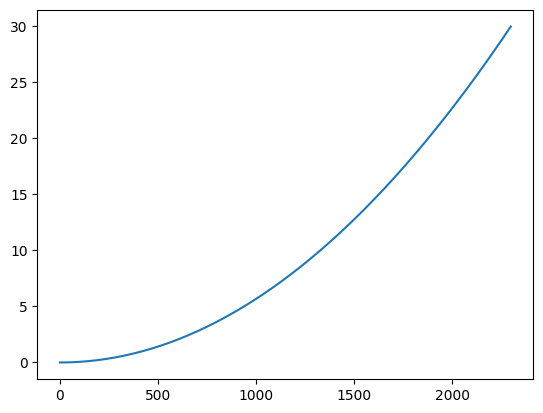

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_6333/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

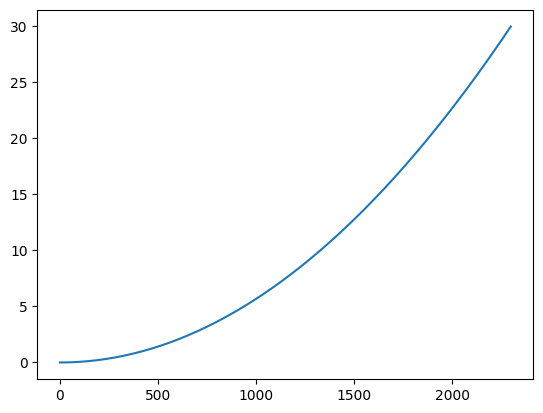

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
#     print(K)  

      

    glob_force = fsolve(lambda x: x @ np.linalg.inv(K)-np.array(vessel_movement),
                        np.zeros(len(vessel_movement)) )
    

    

    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6)

    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [1, 2],
                      [2, 3]]),
        bc_node=list(range(6)),
        bc_val=[0]*6,
        vessel_movement=[
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                        -0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4],
        coefs=[1,1,1,1,1,1])

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_6333/2481667152.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: x @ np.linalg.inv(K)-np.array(vessel_movement),


In [113]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.15044870e-11, -3.10495508e-08,
       -1.23884254e-08,  7.04657047e-08,  6.43332127e-09, -2.06059248e-08,
        5.35302409e-09,  3.01024067e-07, -1.79640370e-08, -3.67193002e-09,
       -1.90480138e-08, -1.34247950e-07, -6.48047257e-07,  2.87114954e-07,
       -3.65357798e-08,  8.58353560e-09, -5.66746706e-08, -1.21510093e-07])

In [114]:
f

array([ 1.14106282e-01,  2.62572069e-03,  2.55588060e-02, -9.86519865e-02,
       -8.33714578e-02,  2.92421528e-01, -6.28839473e-15, -1.76747359e-14,
        1.38278956e-14, -4.96363811e-15,  3.46065331e-15,  2.15815721e-15,
       -1.82076576e-14,  1.86517468e-14, -2.57571742e-14, -8.18789481e-16,
       -4.44089210e-16,  8.88178420e-16, -1.14106282e-01, -2.62572069e-03,
       -2.55588060e-02, -3.58323731e-03,  8.33714578e-02,  1.64003599e-01])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

#     print(elcon)
    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
#     print('d',d)
    # print(f)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_6333/2481667152.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: x @ np.linalg.inv(K)-np.array(vessel_movement),


In [117]:
fors

array([[-3.58092334e-04,  2.91317000e-06,  2.07328954e-05],
       [-5.22221155e-14, -1.24040513e-12, -5.68760317e-13],
       [-9.70890035e-14,  1.09933026e-12,  1.87265481e-12],
       [-1.46563317e-13,  4.29890542e-13, -6.16309087e-13],
       [-2.22710739e-13, -9.05740760e-13,  7.55229213e-14],
       [-1.75859327e-13, -1.46032492e-12,  1.83164595e-12],
       [-2.79776202e-13, -2.59257893e-13, -1.06281650e-12],
       [-2.00284234e-13,  6.79720682e-13,  3.61044528e-13],
       [-2.79776202e-13, -7.28611615e-13,  4.30086522e-13],
       [-2.98427949e-13, -1.18945132e-12,  1.25210953e-12],
       [-2.09610107e-13, -3.87009869e-13, -3.64819286e-13],
       [ 1.42108547e-14, -1.26361231e-12, -1.25277566e-12],
       [-8.52651283e-14, -2.97026292e-12, -9.70470232e-13],
       [ 1.35003120e-13, -4.55024907e-13,  4.45643522e-13],
       [ 1.84741111e-13, -1.94053107e-13, -9.65894031e-13],
       [ 2.30926389e-13, -2.54608626e-13,  1.40754075e-12],
       [ 1.98951966e-13, -1.40285006e-12

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

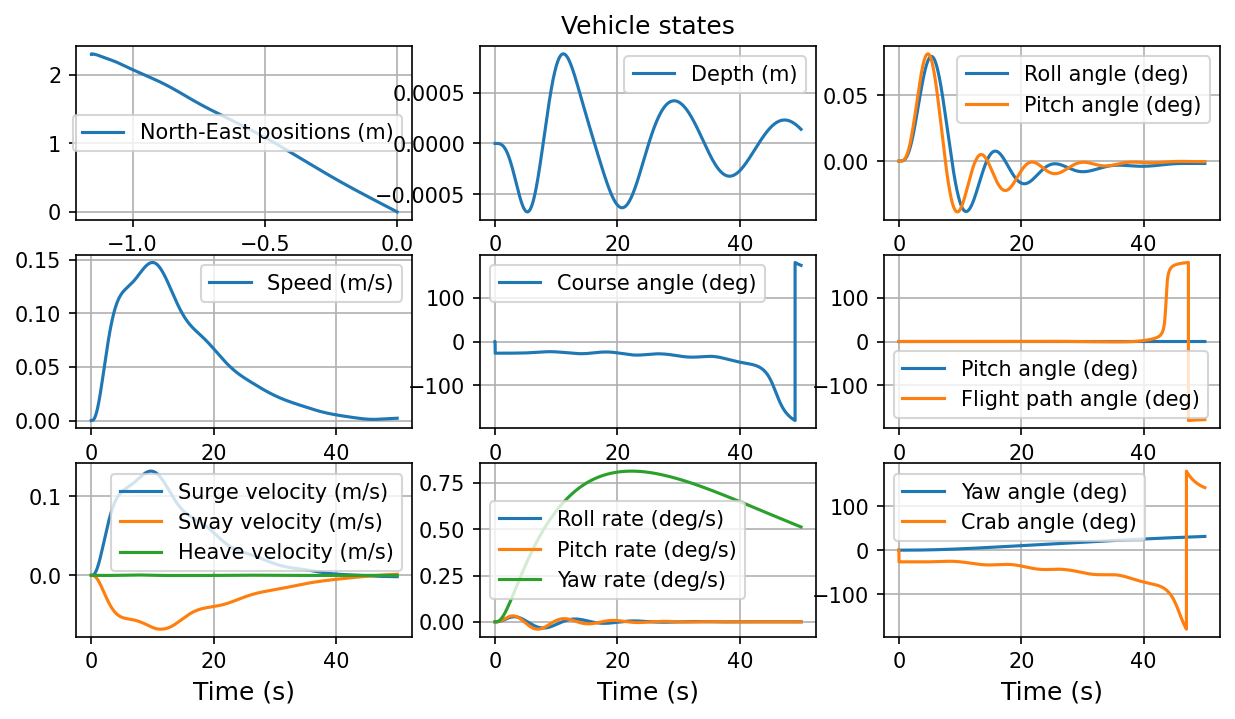

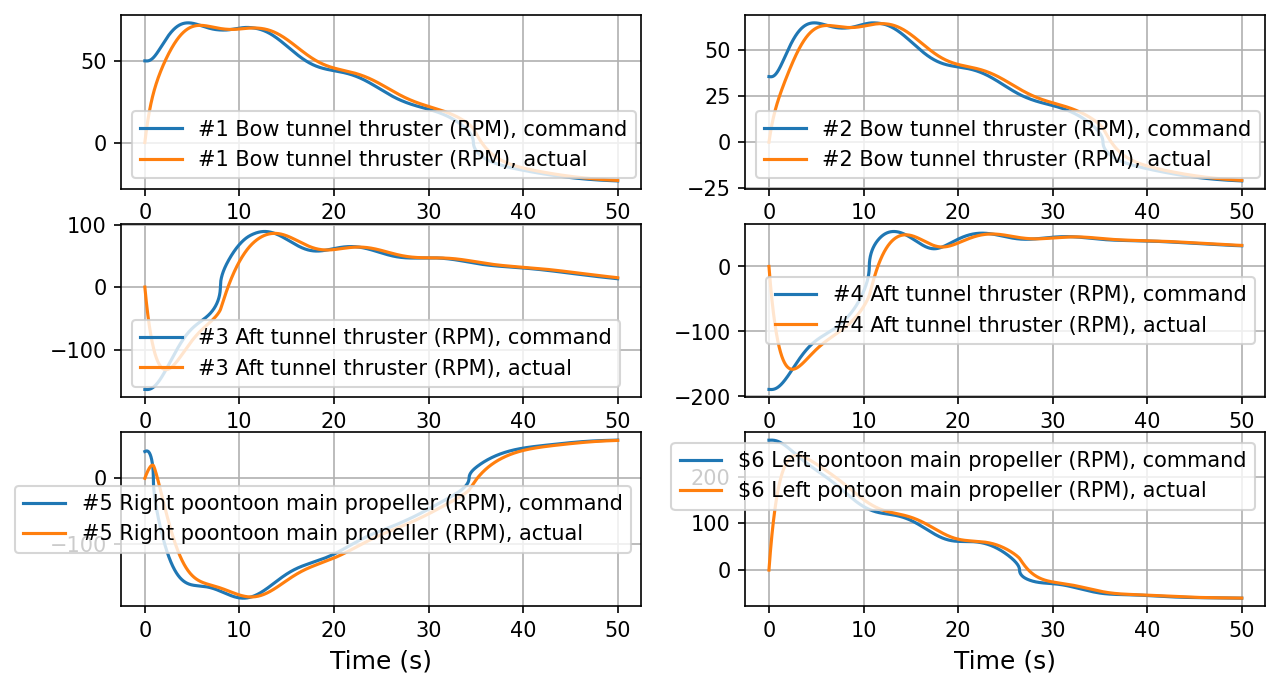

In [123]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

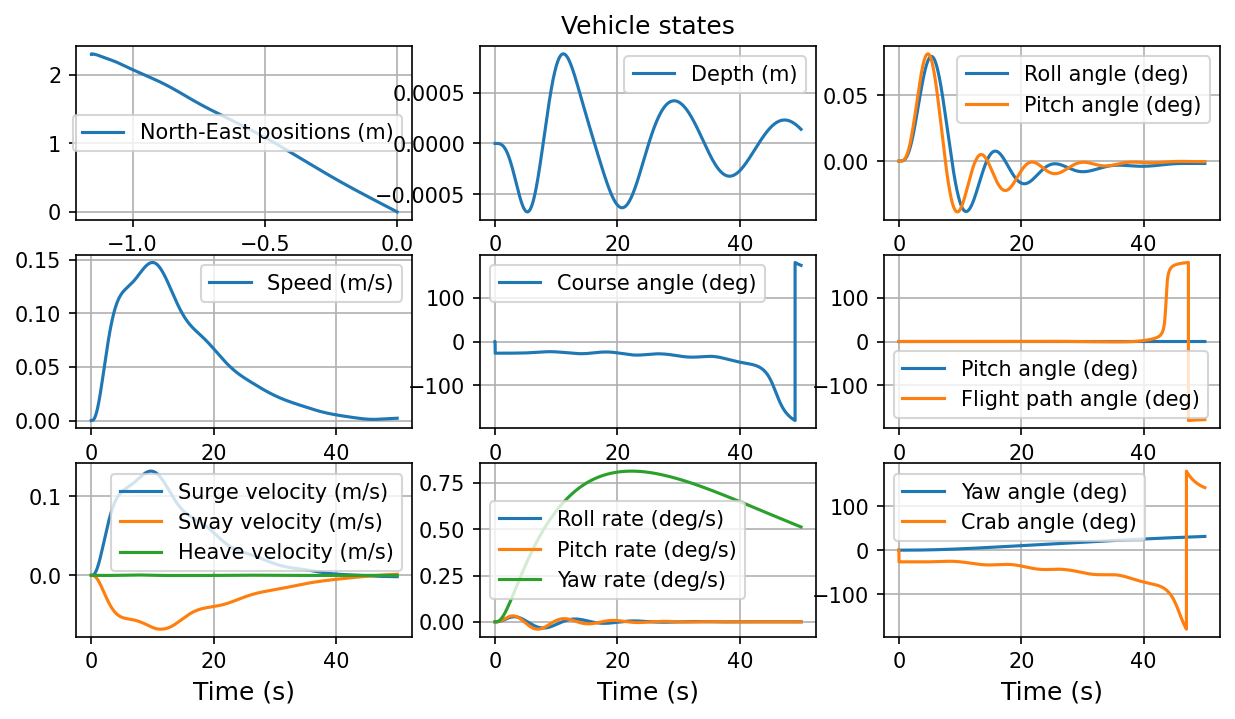

In [125]:
plotVehicleStates(simTime, simData, 3)

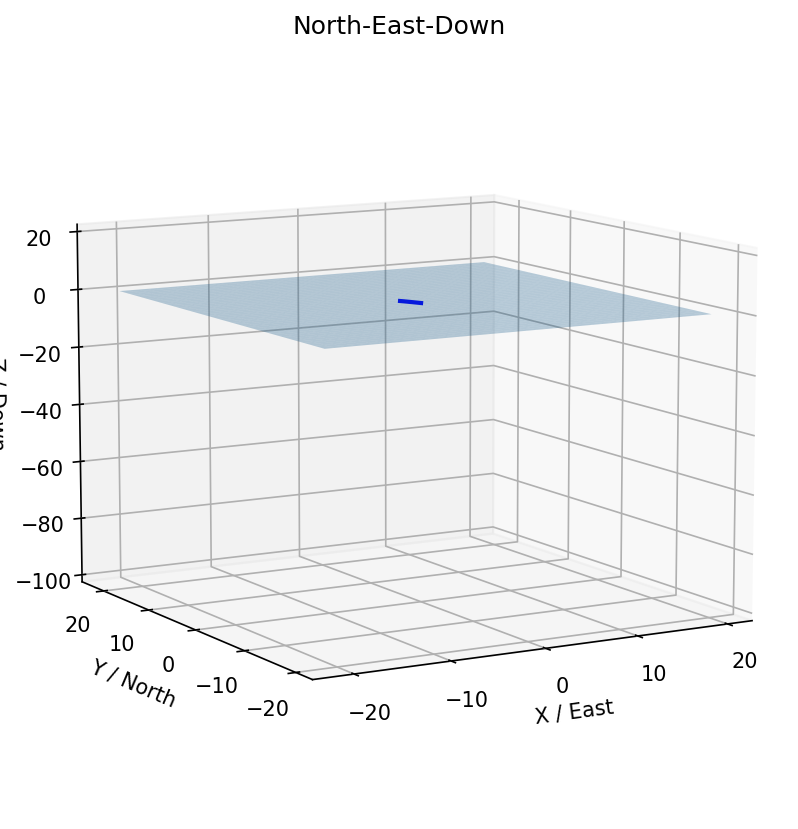

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [131]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(100)]
        self.wall_clock = datetime.now()

In [136]:
def grayscott1d(t, Q, coefs, T):
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]


#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])

#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])


#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]


#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]

#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve  - T.v_m[1]
    vessel_movement[2] = z_ve- T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve - T.v_m[4]
    vessel_movement[5] = psi_v - T.v_m[5]

    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v


#     else:
#         T.v_m[0] = 0.001
#         T.v_m[1] = 0
#         T.v_m[2] = 0
#         T.v_m[3] = 0
#         T.v_m[4] = 0
#         T.v_m[5] = 0

#     print(vessel_movement )
#     print(T.v_m,"l")


#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))

    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(Z0)
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
#         print(T.progression)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

#     T.v_m=np.copy(vessel_movement)

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 25)
T_ = MyTime()

In [138]:
coefs = [1, 1, 1, 1, 1, 1]

In [139]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
#             method='LSODA',
             t_eval=[i*sampleTime for i in range(int(tspan[-1]/(sampleTime)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_6333/2481667152.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: x @ np.linalg.inv(K)-np.array(vessel_movement),


Physical time:  0.3462419251416382  Iteration wall clock time:  0:00:03.080728
Physical time:  1.0891034144585943  Iteration wall clock time:  0:00:24.080141
Physical time:  2.3004065576413693  Iteration wall clock time:  0:00:08.526138
Physical time:  3.095783956181709  Iteration wall clock time:  0:00:06.863802
Physical time:  4.117993124839833  Iteration wall clock time:  0:00:03.046302
Physical time:  5.317732151511669  Iteration wall clock time:  0:00:07.411563
Physical time:  6.9958477718584025  Iteration wall clock time:  0:00:01.881289
Physical time:  7.294179437697822  Iteration wall clock time:  0:00:01.203596
Physical time:  8.550558235782606  Iteration wall clock time:  0:00:04.435782
Physical time:  11.200950883139141  Iteration wall clock time:  0:00:04.426269
Physical time:  11.593601645710478  Iteration wall clock time:  0:00:01.590240
Physical time:  12.084415098924651  Iteration wall clock time:  0:00:01.574352
Physical time:  12.084415098924651  Iteration wall clock 

### Results

In [140]:
fin=us

In [141]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-03 ...  2.500e+01  2.500e+01]
        y: [[ 0.000e+00 -9.228e-19 ...  2.434e-08  2.434e-08]
            [ 4.691e+01  4.691e+01 ...  4.691e+01  4.691e+01]
            ...
            [ 0.000e+00  4.523e-12 ... -3.453e-07 -3.449e-07]
            [ 0.000e+00  4.617e-12 ... -3.524e-07 -3.520e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 92
     njev: 0
      nlu: 0

In [142]:
t=fin.t

In [143]:
fin=fin.y.T

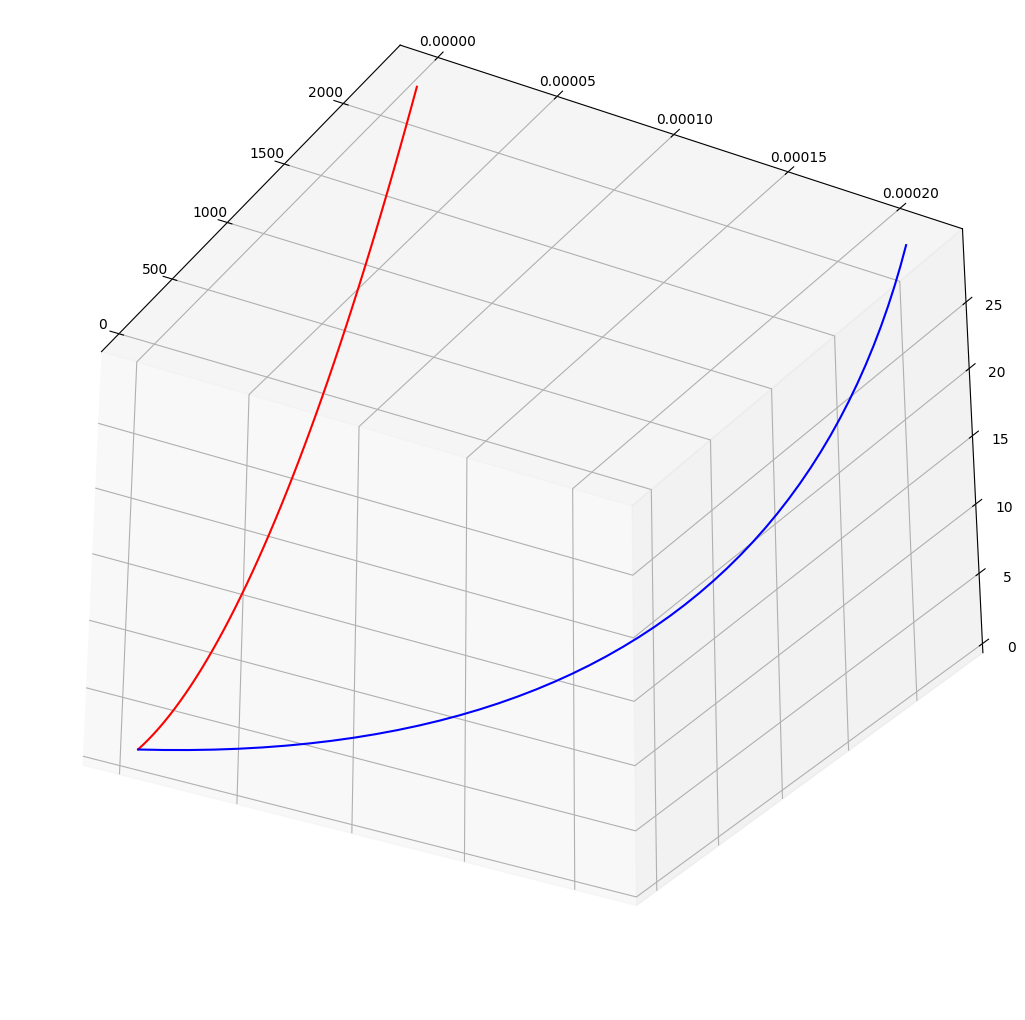

In [144]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [145]:
X,Y,Z

(array([2.43399853e-08, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
        1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
        3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
        5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
        7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
        9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
        1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
        1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
        1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
        1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
        1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
        2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
        2.25144062e+03, 2.29834563e+03]),
 array([-8.66069532e-11,  8.61863700e-06,  1.70616556e-05,  2.53289040e-05,
         3.3420229

In [146]:
X0,Y0,Z0

(array([   0.        ,   46.90501287,   93.81002573,  140.7150386 ,
         187.62005146,  234.52506433,  281.43007719,  328.33509006,
         375.24010292,  422.14511579,  469.05012866,  515.95514152,
         562.86015439,  609.76516725,  656.67018012,  703.57519298,
         750.48020585,  797.38521871,  844.29023158,  891.19524445,
         938.10025731,  985.00527018, 1031.91028304, 1078.81529591,
        1125.72030877, 1172.62532164, 1219.5303345 , 1266.43534737,
        1313.34036024, 1360.2453731 , 1407.15038597, 1454.05539883,
        1500.9604117 , 1547.86542456, 1594.77043743, 1641.67545029,
        1688.58046316, 1735.48547603, 1782.39048889, 1829.29550176,
        1876.20051462, 1923.10552749, 1970.01054035, 2016.91555322,
        2063.82056609, 2110.72557895, 2157.63059182, 2204.53560468,
        2251.44061755, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [147]:
us=fin.T

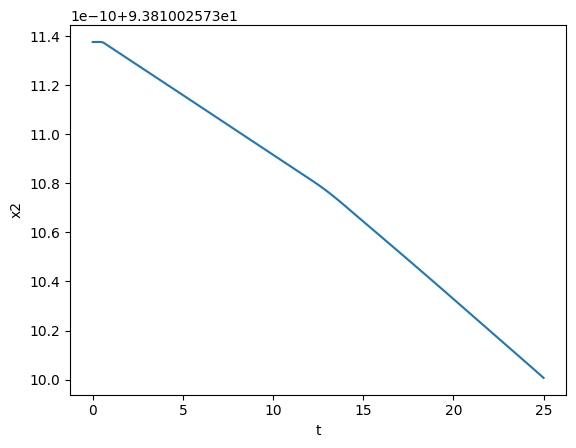

In [148]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

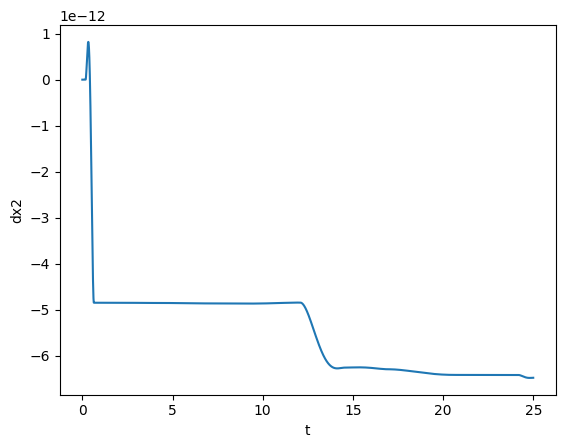

In [149]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

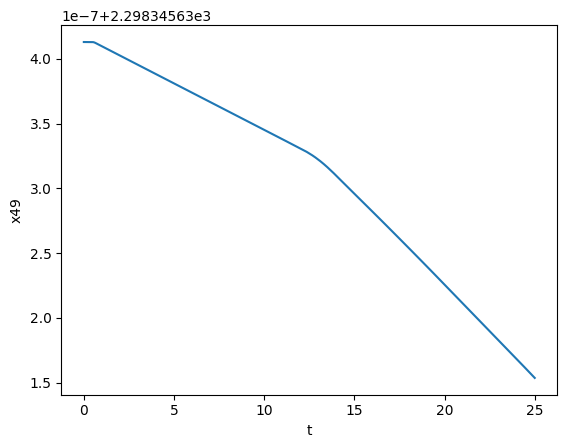

In [150]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

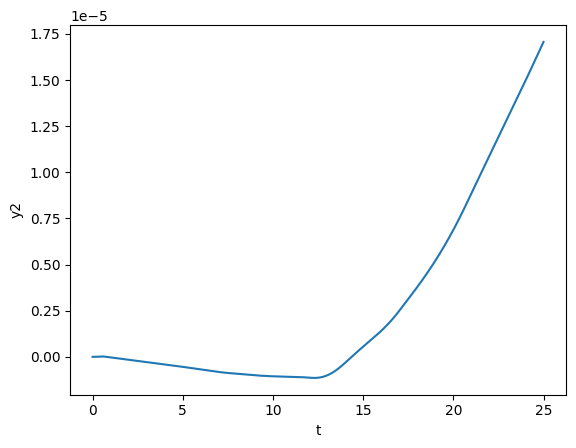

In [151]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

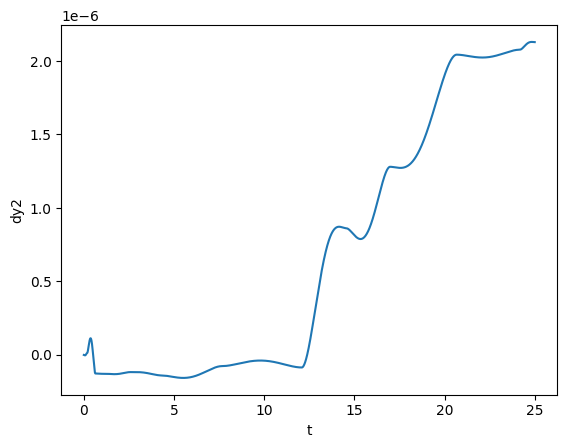

In [152]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

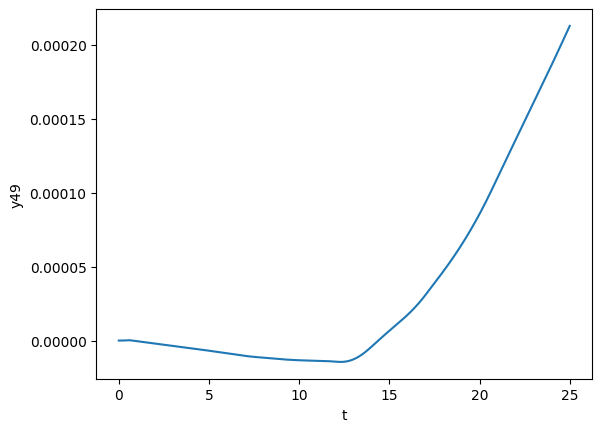

In [153]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

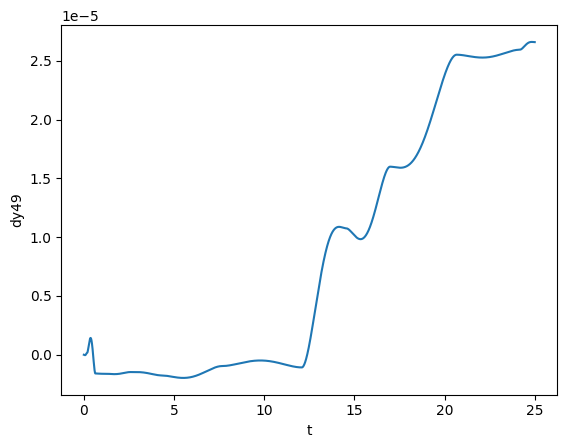

In [154]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

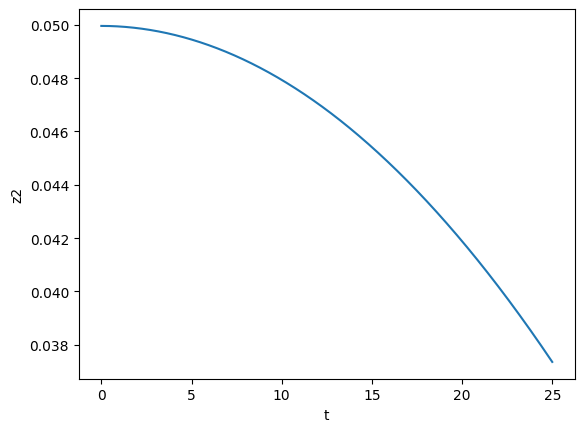

In [155]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

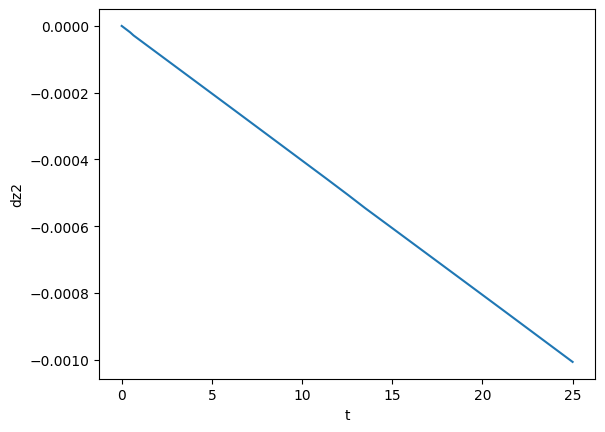

In [156]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

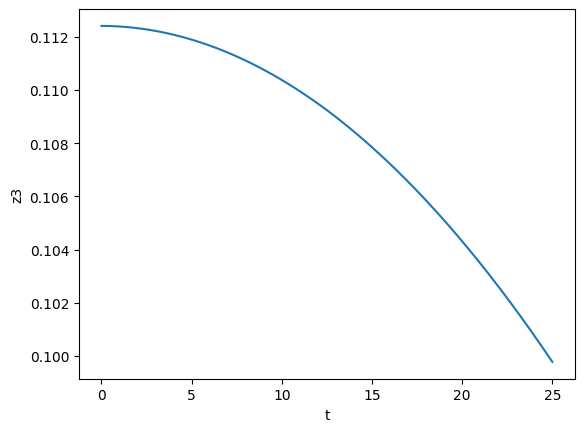

In [157]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

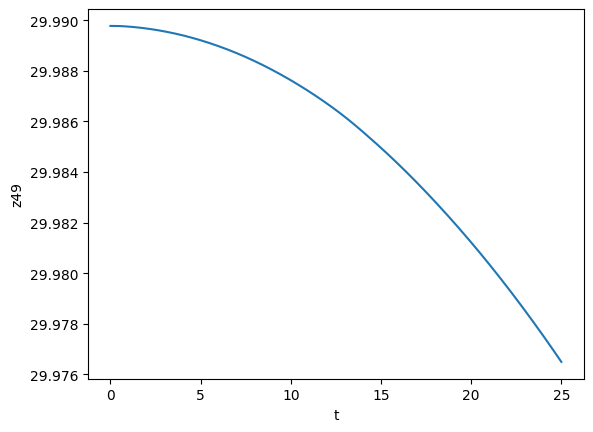

In [158]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

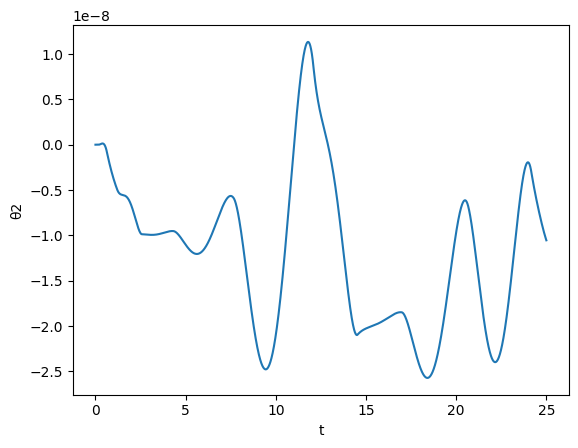

In [159]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

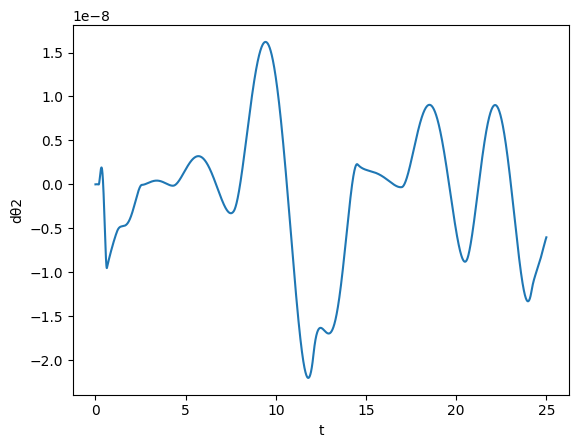

In [160]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

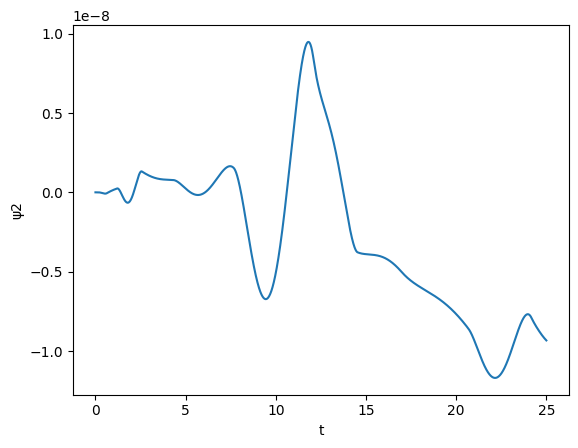

In [161]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

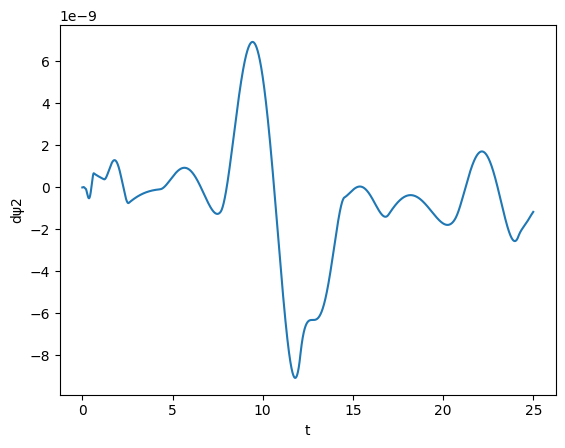

In [162]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()